# Sentence Classification using BERT

Code taken from: https://www.kaggle.com/code/akshat0007/bert-for-sequence-classification/notebook

#### Check GPU access

In [33]:
# Check if CUDA is available and print the current device's name
import torch
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(0))

True
0
NVIDIA GeForce RTX 2070 with Max-Q Design


In [34]:
# Get device name
import tensorflow as tf

# Checking for the GPU
device_name = tf.test.gpu_device_name()
print(device_name)

import torch

device = torch.device("cuda")

In [ ]:
import pandas as pd

# Load Excel file
df = pd.read_excel(r"../../data/training_data/labeled/2025-06-28_labeled_data.xlsx")

# Drop rows with NA or label_strict == -99
df = df.dropna(subset=['label_strict'])
df = df[df['label_strict'] != -99]

# Keep only correct (0) and incorrect (1) labels
df = df[df['label_strict'].isin([0, 1])]

# Create binary label column (same as label_strict)
df['label'] = df['label_strict'].astype(int)

# Rename your text column to 'sentence'
# Replace 'statement_text' with the actual name if needed
df['sentence'] = df['expanded']

# Create a balanced subset:
# - All incorrect (label == 1)
# - Equal number of randomly sampled correct (label == 0)
incorrect_df = df[df['label'] == 1]
correct_df = df[df['label'] == 0].sample(n=incorrect_df.shape[0], random_state=42)

# Combine and shuffle
balanced_df = pd.concat([incorrect_df, correct_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# Print result summary
print(f"Total examples in balanced dataset: {balanced_df.shape[0]}")
print(balanced_df['label'].value_counts())

# Show 5 random rows
balanced_df.head()

Total examples in balanced dataset: 280
label
1    140
0    140
Name: count, dtype: int64


,statement_id,text,section,header,div,p,s,article_id,p_comp,p_value,context,expanded,label_strict,label_kind,label_keywords,label_comment,label,sentence
0,114,p = .358,results,Subjective congruency ratings partly explain b...,12,2.0,1,9567976211032670,=,0.358,Change-detection RTs in Experiment 1 were not ...,Change-detection RTs in Experiment 1 were not ...,1.0,NaN,NaN,NaN,1,Change-detection RTs in Experiment 1 were not ...
1,339,p = .55,results,Inner-crowd effects.,16,2.0,4,9567976211061320,=,0.550,"Importantly, participants in the disagreeingpe...","However, there was no difference between the a...",1.0,NaN,NaN,NaN,1,"However, there was no difference between the a..."
2,155,p = .540,results,Studies 1 and 2: Combined Data Analysis,14,2.0,5,956797618772822,=,0.540,Participant height remained a significant pred...,There was no significant interaction between p...,0.0,NaN,NaN,NaN,0,There was no significant interaction between p...
3,277,p = .146,results,Internal Meta-Analysis,16,4.0,6,956797616636631,=,0.146,The z-standardized significance levels (and df...,The overall interaction effect of Sex Ratio Ã—...,0.0,NaN,NaN,NaN,0,The overall interaction effect of Sex Ratio Ã—...
4,174,p = .141,results,Individual-differences measures and stress res...,13,1.0,2,9567976211005460,=,0.141,Exploratory analyses examining the influence o...,We also examined whether individual difference...,0.0,0.0,NaN,NaN,0,We also examined whether individual difference...


In [36]:
# Divide data into train and test sets
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80/20)
train_df, test_df = train_test_split(
    balanced_df,
    test_size=0.2,
    random_state=42,
    stratify=balanced_df['label']  # Ensures label balance
)

In [37]:
# Check label balance in both training and test sets
train_df['label'].value_counts()

label
1    112
0    112
Name: count, dtype: int64

In [38]:
test_df['label'].value_counts()

label
0    28
1    28
Name: count, dtype: int64

In [39]:
#Another random 5 examples from training set
train_df.sample(5)[['sentence', 'label']]

,sentence,label
166,No significant gender differences emerged in a...,0
199,There was no difference between congruent and ...,1
48,"In all these models, women were more likely to...",0
170,"Depending on the outcome measure, individuals ...",1
248,"As in Experiment 1, neither congruence nor tim...",1


In [40]:
# Get the lists of sentences and their labels.
train_sentences = train_df.sentence.values
train_labels = train_df.label.values

test_sentences = test_df.sentence.values
test_labels = test_df.label.values

In [41]:
from transformers import BertTokenizer

# Load the BERT tokenizer.

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [42]:
# Print the original sentence.
print(' Original: ', train_sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_sentences[0])))

 Original:  For âˆ†Î¸ Ë†crit values derived from highversus low-friction trials, values were different from 0Â° in the live-observation group, t(33) = 5.495, p < .001, d = 0.942, and the interaction group, t(31) = 5.339, p < .001, d = 0.851, but not in the video-observation group, t(29) = 1.232, p = .228, d = 0.225.
Tokenized:  ['for', '[UNK]', '†', '[UNK]', 'e', '†', 'cr', '##it', 'values', 'derived', 'from', 'high', '##vers', '##us', 'low', '-', 'friction', 'trials', ',', 'values', 'were', 'different', 'from', '0', '##a', '##°', 'in', 'the', 'live', '-', 'observation', 'group', ',', 't', '(', '33', ')', '=', '5', '.', '495', ',', 'p', '<', '.', '001', ',', 'd', '=', '0', '.', '94', '##2', ',', 'and', 'the', 'interaction', 'group', ',', 't', '(', '31', ')', '=', '5', '.', '339', ',', 'p', '<', '.', '001', ',', 'd', '=', '0', '.', '85', '##1', ',', 'but', 'not', 'in', 'the', 'video', '-', 'observation', 'group', ',', 't', '(', '29', ')', '=', '1', '.', '232', ',', 'p', '=', '.', '228',

In [43]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in train_sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', train_sentences[0])
print('Token IDs:', input_ids[0])

Original:  For âˆ†Î¸ Ë†crit values derived from highversus low-friction trials, values were different from 0Â° in the live-observation group, t(33) = 5.495, p < .001, d = 0.942, and the interaction group, t(31) = 5.339, p < .001, d = 0.851, but not in the video-observation group, t(29) = 1.232, p = .228, d = 0.225.
Token IDs: [101, 2005, 100, 1526, 100, 1041, 1526, 13675, 4183, 5300, 5173, 2013, 2152, 14028, 2271, 2659, 1011, 15012, 7012, 1010, 5300, 2020, 2367, 2013, 1014, 2050, 7737, 1999, 1996, 2444, 1011, 8089, 2177, 1010, 1056, 1006, 3943, 1007, 1027, 1019, 1012, 29302, 1010, 1052, 1026, 1012, 25604, 1010, 1040, 1027, 1014, 1012, 6365, 2475, 1010, 1998, 1996, 8290, 2177, 1010, 1056, 1006, 2861, 1007, 1027, 1019, 1012, 28977, 1010, 1052, 1026, 1012, 25604, 1010, 1040, 1027, 1014, 1012, 5594, 2487, 1010, 2021, 2025, 1999, 1996, 2678, 1011, 8089, 2177, 1010, 1056, 1006, 2756, 1007, 1027, 1015, 1012, 20666, 1010, 1052, 1027, 1012, 22238, 1010, 1040, 1027, 1014, 1012, 14993, 1012, 102]

In [44]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  277


In [45]:
# We will use some utility function from tensorflow(Tensorflow was my first crush)
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 300

# Helper function
def tokenize_and_pad(sentences, tokenizer, max_len):
    input_ids = []
    for sent in sentences:
        encoded = tokenizer.encode(sent, add_special_tokens=True, truncation=True, max_length=max_len)
        input_ids.append(encoded)
    input_ids = pad_sequences(input_ids, maxlen=max_len, padding='post', truncating='post')
    attention_masks = [[int(token_id > 0) for token_id in seq] for seq in input_ids]
    return input_ids, attention_masks

# Tokenize train and test
train_input_ids, train_attention_masks = tokenize_and_pad(train_sentences, tokenizer, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_and_pad(test_sentences, tokenizer, MAX_LEN)

In [46]:
# Creating the attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [47]:
# # We will call the train_test_split() function from sklearn
# from sklearn.model_selection import train_test_split


# # Use this to split input_ids and labels
# train_inputs, validation_inputs, labels_train, labels_val = train_test_split(
#     train_input_ids, train_labels, test_size=0.2, random_state=2018, stratify=train_labels)

# # Use the same split to split the attention masks
# train_masks, validation_masks, _, _ = train_test_split(
#     train_attention_masks, train_labels, test_size=0.2, random_state=2018, stratify=train_labels)

In [48]:
print(len(train_input_ids), len(train_labels))

224 224


In [49]:
import torch

# Convert training data to tensors
train_inputs = torch.tensor(train_input_ids)        # your tokenized & padded training inputs
train_labels = torch.tensor(train_labels)           # training labels
train_masks = torch.tensor(train_attention_masks)   # attention masks for training

# Convert test data to tensors
test_inputs = torch.tensor(test_input_ids)           # tokenized test inputs
test_labels = torch.tensor(test_labels)               # test labels
test_masks = torch.tensor(test_attention_masks)     # attention masks for test

In [50]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

batch_size = 32

# Create the DataLoader for the training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [51]:
#Loading the pre-trained BERT model from huggingface library

from transformers import BertForSequenceClassification, BertConfig
from torch.optim import AdamW

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,   
    output_attentions = False, 
    output_hidden_states = False, )

# Teeling the model to run on GPU
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [52]:
# AdamW is an optimizer which is a Adam Optimzier with weight-decay-fix
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [53]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
scheduler

Define a helper function for calculating accuracy.

In [54]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [55]:
#Creating the helper function to have a watch on elapsed time

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## Let's start the training process

In [57]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # # ========================================
    # #               Validation
    # # ========================================
    # # After the completion of each training epoch, measure our performance on
    # # our validation set.

    # print("")
    # print("Running Validation...")

    # t0 = time.time()

    # # Put the model in evaluation mode--the dropout layers behave differently
    # # during evaluation.
    # model.eval()

    # # Tracking variables 
    # eval_loss, eval_accuracy = 0, 0
    # nb_eval_steps, nb_eval_examples = 0, 0

    # # Evaluate data for one epoch
    # for batch in validation_dataloader:
        
    #     # Add batch to GPU
    #     batch = tuple(t.to(device) for t in batch)
        
    #     # Unpack the inputs from our dataloader
    #     b_input_ids, b_input_mask, b_labels = batch
        
    #     # Telling the model not to compute or store gradients, saving memory and
    #     # speeding up validation
    #     with torch.no_grad():        

    #         # Forward pass, calculate logit predictions.
    #         # This will return the logits rather than the loss because we have
    #         # not provided labels.
    #         # token_type_ids is the same as the "segment ids", which 
    #         # differentiates sentence 1 and 2 in 2-sentence tasks.
    #         # The documentation for this `model` function is here: 
    #         # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    #         outputs = model(b_input_ids, 
    #                         token_type_ids=None, 
    #                         attention_mask=b_input_mask)
        
    #     # Get the "logits" output by the model. The "logits" are the output
    #     # values prior to applying an activation function like the softmax.
    #     logits = outputs[0]

    #     # Move logits and labels to CPU
    #     logits = logits.detach().cpu().numpy()
    #     label_ids = b_labels.to('cpu').numpy()
        
    #     # Calculate the accuracy for this batch of test sentences.
    #     tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
    #     # Accumulate the total accuracy.
    #     eval_accuracy += tmp_eval_accuracy

    #     # Track the number of batches
    #     nb_eval_steps += 1

    # # Report the final accuracy for this validation run.
    # print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    # print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.63
  Training epoch took: 0:00:15

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.64
  Training epoch took: 0:00:17

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.60
  Training epoch took: 0:00:17

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.60
  Training epoch took: 0:00:17

Training complete!


In [58]:
print(loss_values) #Having a view of stored loss values in the list

[0.6313880426543099, 0.6373624290738787, 0.6001586232866559, 0.5988414883613586]


In [60]:
#Loading the test data and applying the same preprocessing techniques which we performed on the train data
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler

prediction_inputs = torch.tensor(test_input_ids)
prediction_masks = torch.tensor(test_attention_masks)
prediction_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_27596\1985238333.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction_labels = torch.tensor(test_labels)


In [62]:
#Evaluating our model on the test set

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

Predicting labels for 56 test sentences...


We will use Matthews Correlation Coefficient(MCC) to evaluate our model. MCC is used in many areas of Natural Language Processing. Also, it's a great metric to be used for imbalanced dataset

Link: https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a

In [63]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 140 of 309 (45.31%)


In [64]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [65]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.322


### Confusion Matrix

In [66]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Convert logits to predicted class labels
# Each element in predictions is a batch of logits
flat_predictions = np.concatenate(predictions, axis=0)
predicted_labels = np.argmax(flat_predictions, axis=1)

# Step 2: Flatten the true labels
flat_true_labels = np.concatenate(true_labels, axis=0)

# Step 3: Generate the confusion matrix
conf_matrix = confusion_matrix(flat_true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Optional: Print a classification report (includes precision, recall, F1)
print("\nClassification Report:")
print(classification_report(flat_true_labels, predicted_labels, target_names=["class 0", "class 1"]))


Confusion Matrix:
[[19  9]
 [10 18]]

Classification Report:
              precision    recall  f1-score   support

     class 0       0.66      0.68      0.67        28
     class 1       0.67      0.64      0.65        28

    accuracy                           0.66        56
   macro avg       0.66      0.66      0.66        56
weighted avg       0.66      0.66      0.66        56



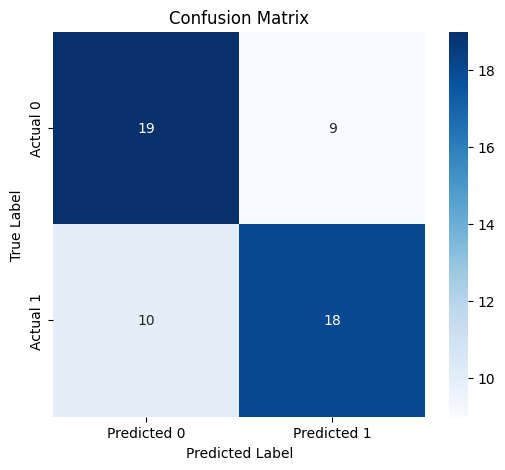

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming flat_true_labels and predicted_labels are defined as before

conf_matrix = confusion_matrix(flat_true_labels, predicted_labels)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
